In [1]:
import olca_ipc as ipc
import olca_schema as o
import pandas as pd
import numpy as np

from typing import Callable

In [2]:
technosphere = pd.DataFrame(
    data=[
        [1.0, -50.0, -1.0, 0.0],
        [-0.01, 1.0, -1.0, 0.0],
        [0.0, 0.0, 1.0, -1.0],
        [0.0, 0.0, 0.0, 100],
    ],
    columns=[
        "electricity production",
        "aluminium production",
        "aluminium foil production",
        "sandwitch package production",
    ],
    index=[
        "electricity [MJ]",
        "aluminium [kg]",
        "aluminium foil [kg]",
        "sandwitch package [Item(s)]",
    ],
)
print(technosphere)

                             electricity production  aluminium production  \
electricity [MJ]                               1.00                 -50.0   
aluminium [kg]                                -0.01                   1.0   
aluminium foil [kg]                            0.00                   0.0   
sandwitch package [Item(s)]                    0.00                   0.0   

                             aluminium foil production  \
electricity [MJ]                                  -1.0   
aluminium [kg]                                    -1.0   
aluminium foil [kg]                                1.0   
sandwitch package [Item(s)]                        0.0   

                             sandwitch package production  
electricity [MJ]                                      0.0  
aluminium [kg]                                        0.0  
aluminium foil [kg]                                  -1.0  
sandwitch package [Item(s)]                         100.0  


In [6]:
interventions = pd.DataFrame(
    data=[
        [0.0, -5.0, 0.0, 0.0],
        [-0.5, 0.0, 0.0, 0.0],
        [3.0, 0.0, 0.0, 0.0],
        [2.0, 10.0, 0.0, 1.0],
    ],
    columns=technosphere.columns,
    index=[
        "bauxite [kg]",
        "crude oil [kg]",
        "CO2 [kg]",
        "solid waste [kg]",
    ],
)
print(interventions)

                  electricity production  aluminium production  \
bauxite [kg]                         0.0                  -5.0   
crude oil [kg]                      -0.5                   0.0   
CO2 [kg]                             3.0                   0.0   
solid waste [kg]                     2.0                  10.0   

                  aluminium foil production  sandwitch package production  
bauxite [kg]                            0.0                           0.0  
crude oil [kg]                          0.0                           0.0  
CO2 [kg]                                0.0                           0.0  
solid waste [kg]                        0.0                           1.0  


In [10]:
f = [
    0.0,
    0.0,
    0.0,
    10,
]
s = np.linalg.solve(technosphere.to_numpy(), f)
g = interventions.to_numpy() @ s
print(pd.DataFrame(g, index=interventions.index))


                      0
bauxite [kg]      -1.01
crude oil [kg]    -5.10
CO2 [kg]          30.60
solid waste [kg]  22.52


In [ ]:
## Inventory calculations

In [11]:
client = ipc.Client(8080)


As we have nothing in our database, we first need to create the units and flow properties (quantity kinds) in which the flows of the examples are measured

In [ ]:
mass_units = o.new_unit_group("Mass units", "kg")
energy_units = o.new_unit_group("Energy units", "MJ")
counting_units = o.new_unit_group("Counting units", "Item(s)")
mass = o.new_flow_property("Mass", mass_units)
energy = o.new_flow_property("Energy", energy_units)
count = o.new_flow_property("Number of items", counting_units)

client.put_all(
    mass_units,
    energy_units,
    counting_units,
    mass,
    energy,
    count,
)


 we can get the flow property Mass by its name:

In [ ]:
print(client.get(o.FlowProperty, name="Mass").to_json())


In [ ]:
{
  "@type": "FlowProperty",
  "@id": "b24a123b-f5a1-40fb-a481-afeeb50f6159",
  "lastChange": "2023-01-26T13:36:37.954Z",
  "name": "Mass",
  "unitGroup": {
    "@type": "UnitGroup",
    "@id": "3e912f50-9490-473c-89fc-1393ed2eea03",
    "name": "Mass units"
  },
  "version": "01.00.000"
}


Next, we create the flows of the example. In the snippet below, it iterates over the rows of the data frames and creates a product or elementary flow for each rowm

In [ ]:
def create_flow(
    row_label: str, fn: Callable[[str, o.FlowProperty], o.Flow]
) -> o.Flow:
    parts = row_label.split("[")
    name = parts[0].strip()
    unit = parts[1][0:-1].strip()
    match unit:
        case "kg":
            prop = mass
        case "MJ":
            prop = energy
        case "Item(s)":
            prop = count
    flow = fn(name, prop)
    client.put(flow)
    return flow


tech_flows = [create_flow(label, o.new_product) for label in technosphere.index]
envi_flows = [
    create_flow(label, o.new_elementary_flow) for label in interventions.index
]


Then we iterate over the columns of the data frames and create the corrsponding processes with their inputs and outputs of the flows we just created.

In [ ]:
def create_process(index: int, name: str) -> o.Process:
    process = o.new_process(name)

    def exchange(flow: o.Flow, value: float) -> o.Exchange | None:
        if value == 0:
            return None
        if value < 0:
            return o.new_input(process, flow, abs(value))
        else:
            return o.new_output(process, flow, value)

    for (i, tech_flow) in enumerate(tech_flows):
        value = technosphere.iat[i, index]
        e = exchange(tech_flow, value)
        if e and i == index:
            e.is_quantitative_reference = True

    for (i, envi_flow) in enumerate(envi_flows):
        value = interventions.iat[i, index]
        exchange(envi_flow, value)

    client.put(process)
    return process


processes = [
    create_process(index, name)
    for (index, name) in enumerate(technosphere.columns)
]


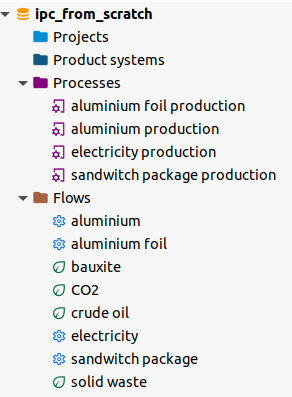

Now we can calculate the inventory of this system. We create a calculation setup for the sandwitch packaging process as calculation target.

In [ ]:
setup = o.CalculationSetup(
    target=o.Ref(ref_type=o.RefType.Process, id=processes[3].id),
    unit=count.unit_group.ref_unit,  # "Item(s)"
    amount=10,
)
result = client.calculate(setup)
result.wait_until_ready()


When the result is ready, we can query the inventory from it:

In [ ]:
inventory = result.get_total_flows()
print(
    pd.DataFrame(
        data=[
            (
                i.envi_flow.flow.name,
                i.envi_flow.is_input,
                i.amount,
                i.envi_flow.flow.ref_unit,
            )
            for i in inventory
        ],
        columns=["Flow", "Is input?", "Amount", "Unit"],
    )
)


when we do not need the result anymore, we need to dispose it so that allocated resources can be freed on the openLCA side:

In [ ]:
result.dispose()
